# Example Agent web search

Summarize a web search and perform an evaluation of whether the question is answered or not

In [1]:
import time

from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.chat_models import ChatOllama
from langchain.output_parsers import CommaSeparatedListOutputParser

from typing_extensions import TypedDict

from langgraph.graph import StateGraph

from langchain_core.prompts import PromptTemplate

from IPython.display import Image, display

llm = ChatOllama(model = "llama3", base_url="http://ollama:11434")

In [2]:
class State(TypedDict):
    question: str
    enhancedQuestions: list[str]
    webSearch: str
    generation: str
    nPoints: int
    nQuestions: int
    graded: str
    iter: int
    maxIters: int

## Question enhancement

In [3]:
# Summarizer node
prompt = """You are an expert in creating search queries for web searching. Create {nQuestions} questions to retrieve information regarding the following question {question}.
Reply in the same anguage as the original question. Reply only with the generated questions separated by line breaks and no preamble."""

promptTemplate = PromptTemplate.from_template(prompt)

questionEnhancer = promptTemplate | llm

def enhance(state: State):
    print("-----------Enhancing question-----------")
    questions = questionEnhancer.invoke({"nQuestions": str(state["nQuestions"]), "question": state["question"]}).content
    questions = [x for x in questions.split("\n") if x !=""]
    print(f"{questions=}")
    return {"enhancedQuestions": questions, "iter": state["iter"] + 1} 

## Search node

In [4]:
# search node
webSearch = DuckDuckGoSearchResults(max_results=2,)

def getInfo(state: State):
    print("-----------Searching-----------")
    questions = [state["question"]] + state["enhancedQuestions"]
    result = ""
    for question in questions:
        print(result)
        result += question + ":\n\n" + webSearch.invoke(question)
        time.sleep(0.5)
    print(result)
    return {"webSearch": result}

## Summarizing node

In [6]:
# Summarizer node
prompt = """You are an expert in summarizing text. Summarize the following text in {nPoints} bulletpoints,

{text}.

Reply in the same language as the text.
Reply only with the {nPoints} bullets and no preamble."""

promptTemplate = PromptTemplate.from_template(prompt)

summarizer = promptTemplate | llm

def summarize(state: State):
    print("-----------Summarizing-----------")
    result = summarizer.invoke({"nPoints": str(state["nPoints"]), "text": state["webSearch"]}).content
    print(result)
    return {"generation": result} # "Potatoes are a yellow fruit that grows on trees. They are delicious but almost extinct."

## Check answer

In [7]:
prompt = """You are an expert grader. Determine if the following bulletpoints,

{bullets}

answers the following question {question}.

Reply only "Sufficient" if the bulletpoints answer the question and "insufficient" if the question is not answered. Do not give any preamble."""

promptTemplate = PromptTemplate.from_template(prompt)

grader = promptTemplate | llm

def grade(state: State):
    print("-----------Grading answer-----------")
    result = grader.invoke({"bullets": str(state["generation"]), "question": state["question"]}).content
    print(result)
    return {"graded": result}

## Route graded answer

In [8]:
def gradeRouter(state: State):
    grade = state["graded"]
    print("-------------Routing---------------")
    print(grade)
    if grade == "Sufficient" or state["iter"] >= state["maxIters"]:
        return "__end__"
    else:
        return "enhancer"

## Build graph

In [9]:
graphBuilder = StateGraph(State)

graphBuilder.add_node("generator", summarize)
graphBuilder.add_node("search", getInfo)
graphBuilder.add_node("grader", grade)
graphBuilder.add_node("enhancer", enhance)

graphBuilder.add_edge("enhancer", "search")
graphBuilder.add_edge("search", "generator")
graphBuilder.add_edge("generator","grader")

graphBuilder.add_conditional_edges("grader", gradeRouter,
                                   {"__end__": "__end__", "enhancer": "enhancer"})

graphBuilder.set_entry_point("enhancer")
graph = graphBuilder.compile()


## Visualize graph

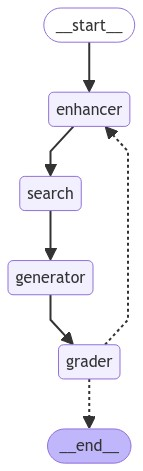

In [10]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Testing

In [11]:
finalState = graph.invoke({"question": "Vad gör en barnskötare?", 
                           "nPoints": 4, "nQuestions":3,
                           "maxIters":3, "iter":0})

-----------Enhancing question-----------
questions=['Vad är definitionen av barnskötare?', 'Hur beskrivs funktionen hos barnskötare i olika kulturer?', 'Vilken information finns tillgänglig om traditionella och moderna barnskötare?']
-----------Searching-----------

Vad gör en barnskötare?:

[snippet: Vad gör en barnskötare? En barnskötare arbetar på en förskola med uppdraget att se till så att alla barn får sina behov tillgodosedda samtidigt som de utvecklas, mår bra och har roligt. Du blir barnskötare genom att till exempel gå barn- och fritidsprogrammet på gymnasiet eller genom en yrkesutbildning på komvux., title: Hur blir man barnskötare? | Indeed.com Sverige, link: https://se.indeed.com/karriarrad/hitta-ett-jobb/hur-bli-barnskotare], [snippet: Vad gör en barnskötare? Barnskötaren och förskollärarna hjälps åt med arbetsuppgifterna i det dagliga arbetet. Barnskötaren deltar i lek och aktiviteter och hjälper till vid måltider och sovstunder. Förskollärarna har det pedagogiska ansvar

In [12]:
finalState = graph.invoke({"question": "What are common pitfalls in statistics??", 
                           "nPoints": 4, "nQuestions":3,
                           "maxIters":3, "iter":0})

-----------Enhancing question-----------
questions=['What are common mistakes statisticians make when analyzing data?', 'What pitfalls do researchers encounter when interpreting statistical results?', 'How can biases and assumptions impact statistical conclusions?']
-----------Searching-----------

What are common pitfalls in statistics??:

[snippet: Data analysis and statistics can be a complex field with many common fallacies to be aware of. Knowledge of these pitfalls and actively working to avoid them will result in more accurate statistical conclusions that contribute to the advancement of evidence-based knowledge., title: 5 Statistical Fallacies and How to Avoid Them - Statology, link: https://www.statology.org/5-statistical-fallacies-avoid-them/], [snippet: The truth behind statistics: 7 Myths About Statistics, from the misconception of correlation implying causation to the misuse of p-values., title: 7 Myths About Statistics You Need to Stop Believing, link: https://statisticse